In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import pandas as pd

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility

In [2]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Generate data

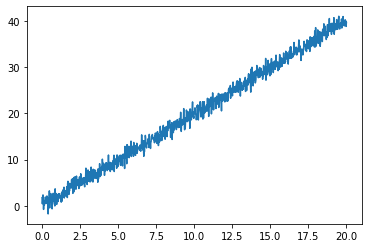

In [3]:
# generate linear time series data with some noise
n = 1000
x_max = 20
slope = 2
scale = 1

x_data = torch.from_numpy(np.linspace(0, x_max, n).reshape(-1, 1).astype(np.float32))
y_data = slope * x_data + np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)

plt.plot(x_data, y_data)
plt.show()

### Split data set

In [4]:
def train_data(data, seq_length):
      
    data_x = []
    data_y = []
    
    # iterate through the array, one sequence at a time
    for n in range(0, data.shape[0]-seq_length):
        # The features
        data_x.append(data[n:n+seq_length])
        # The targets, shifted by one
        data_y.append(data[n+seq_length:n+seq_length+1])
        
    return data_x,data_y

In [5]:
sequence_len = 8
x,y = train_data(y_data,sequence_len)
x = torch.cat(x,dim = -1)
x = torch.t(x)
y = torch.cat(y,dim = 0)

In [6]:
x.shape,y.shape

(torch.Size([992, 8]), torch.Size([992, 1]))

In [7]:
scaler= StandardScaler()
x_new = torch.tensor(scaler.fit_transform(x),dtype=torch.float32)
x_new.dtype,x.dtype

(torch.float32, torch.float32)

In [8]:
lengths = [int(x.shape[0]*0.6), int(x.shape[0]*0.8)]
x_train, x_val, x_test = x[:lengths[0],], x[lengths[0]:lengths[1],:], x[lengths[1]:,:]
y_train, y_val, y_test = y[:lengths[0],], y[lengths[0]:lengths[1],:], y[lengths[1]:,:]

# Define model that predicts quantiles

In [9]:
class QuantileLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, quantile=0.5, mode=None,method=None,significance=None, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=quantile_loss,
            criterion_args={"quantile": quantile},
            method=method,
            mode=mode,
            significance=significance,
            **kwargs
        )
        n_quantiles = 1 if isinstance(quantile, float) else len(quantile)
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, n_quantiles) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

# Train model to predict multiple quantiles

In [10]:
input_size = sequence_len
output_size = 1
hidden_size = 64
optimizer = optim.Adam
optimizer_args = {"lr": 0.005}
max_epochs = 30
batch_size = 16
quantile = [0.025, 0.5, 0.975]

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    method='conformal',
    mode = 'time_series',
    significance=0.1,
    optimizer_args=optimizer_args,
    scaler = None
    # scaler= StandardScaler()
)

In [11]:
model.fit(x_train, y_train, max_epochs=max_epochs, batch_size=batch_size)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 18.9 K
1 | linear | ModuleList | 195   
--------------------------------------
19.1 K    Trainable params
0         Non-trainable params
19.1 K    Total params
0.077     Total estimated model params size (MB)


/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of c

Epoch 0:  61%|▌| 23/38 [00:00<00:00, 195.07it/s, loss=14.1, v_num=162, train_los
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█| 38/38 [00:00<00:00, 245.75it/s, loss=14.1, v_num=162, train_los
Epoch 1:  61%|▌| 23/38 [00:00<00:00, 198.11it/s, loss=8.95, v_num=162, train_los
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 38/38 [00:00<00:00, 257.39it/s, loss=8.95, v_num=162, train_los
Epoch 2:  61%|▌| 23/38 [00:00<00:00, 198.00it/s, loss=5.75, v_num=162, train_los
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 38/38 [00:00<00:00, 231.40it/s, loss=5.75, v_num=162, train_los
Epoch 3:  61%|▌| 23/38 [00:00<00:00, 182.01it/s, loss=3.39, v_num=162, train_los
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 38/38 [00:00<00:00, 226.50it/s, loss=3.39, v_num=162, train_los
Epoch 4:  61%|▌| 23/38 [00:00<00:00, 181.38it/s, loss=2.15, v_num=162, train_los
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█| 38/38 [00:00<00:00, 231.94it/s, loss=2.15, v_num=162, train_los
Epoch 5:  61%|▌| 23/38 [00:00<00:00

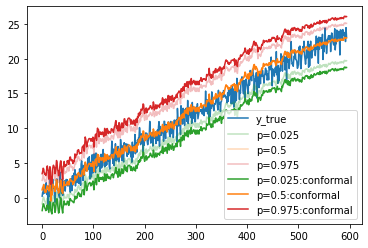

In [12]:
# plot x_train
y_pred = model.predict(x_train)
y_pred_conformal = model.conformal_predict(x_train)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(np.arange(x_train.shape[0]), y_train, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(np.arange(x_train.shape[0]), y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(np.arange(x_train.shape[0]), y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()

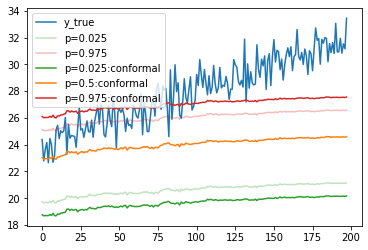

In [13]:
# plot x_test
y_pred = model.predict(x_val)
y_pred_conformal = model.conformal_predict(x_val)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(np.arange(x_val.shape[0]), y_val, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    if i != 1:
        plt.plot(np.arange(x_val.shape[0]), y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(np.arange(x_val.shape[0]), y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()

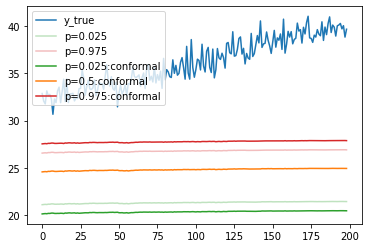

In [14]:
# plot x_test
y_pred = model.predict(x_test)
y_pred_conformal = model.conformal_predict(x_test)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(np.arange(x_test.shape[0]), y_test, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    if i != 1:
        plt.plot(np.arange(x_test.shape[0]), y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(np.arange(x_test.shape[0]), y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()